In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Verlet algorithm

Work out an update rule for $x(t+\Delta t)$ using Taylor series for $x(t+\Delta t)$ and $x(t-\Delta t)$  and $dx/dt = v(t)$ and $a(t) = d^2x/dt^2$.
\begin{equation}
x(t+\Delta t) = x(t) + v(t) \Delta t + \frac{1}{2} a(t) \Delta t^2 + O(\Delta t^3)
\end{equation}
and
\begin{equation}
x(t-\Delta t) = x(t) - v(t) \Delta t + \frac{1}{2} a(t) \Delta t^2 - O(\Delta t^3)
\end{equation}
add together and solve for $x(t+\Delta t)$ gives
\begin{equation}
x(t+\Delta t) = 2 x(t) - x(t-\Delta t) + a(t) \Delta t^2 + O(\Delta t^4)
\end{equation}
This equation is $O(\Delta t^4)$ because the 3rd order terms cancel.

In [2]:
# first verlet update rule to get x(\Delta t) from initial conditions
def verlet0(r0, v0, a0, dt):
    # note, r0, v0, a0 can be N x d arrays where N is the # of particles and d is the dimension
    return r0 + v0*dt + 0.5*a0*dt*dt

In [3]:
# verlet update rule
def verlet(r0, r1, a, dt):
    # note, r0, v0, a0 can be N x d arrays where N is the # of particles and d is the dimension
    return 2.0*r1 - r0 + a*dt*dt

## Free-fall calculation

In [4]:
# here a(t) = (0, -g) for all time (up is taken positive)

dt = 0.1

r0 = array([0.0, 3.0])  # particle starts at a height of 3m
v0 = array([1.0, 5.0])   # initial velocity of particle
a = array([0.0,-9.8])

rs = [r0]   # this will keep a list of our trajectories

# compute next position using verlet0
r1 = verlet0(r0, v0, a, dt)
rs.append(r1)

r2 = verlet(r0, r1, a, dt)

print(r1)
print(r2)

[0.1   3.451]
[0.2   3.804]


In [5]:
# these #'s should be checked with the above formula by just plugging into a calculator, but they look ok

In [6]:
# let's calculate a trajectory using 100 dt steps

# here a(t) = (0, -g) for all time (up is taken positive)

dt = 0.01

r0 = array([0.0, 3.0])  # particle starts at a height of 3m
v0 = array([1.0, 5.0])   # initial velocity of particle
a = array([0.0,-9.8])

rs = [r0]   # this will keep a list of our trajectories

# compute next position using verlet0
r1 = verlet0(r0, v0, a, dt)
rs.append(r1)

# now rs has 2 positions, r0 and r1 so we can go ahead and keep using verlet
Nt = 100  # # of time steps

for i in range(Nt-2):   # -2 because we already have 2 positions
    r0 = rs[-2]   # 2nd last position in our list
    r1 = rs[-1]   # previous position in our list
    
    # if we needed to, we could calculate a(t) here, but our a is constant
    rt = verlet(r0, r1, a, dt)
    rs.append(rt)
rs = array(rs)
print(shape(rs))
# x(t) is in 1st column, y(t) is in 2nd column 

(100, 2)


<IPython.core.display.Javascript object>


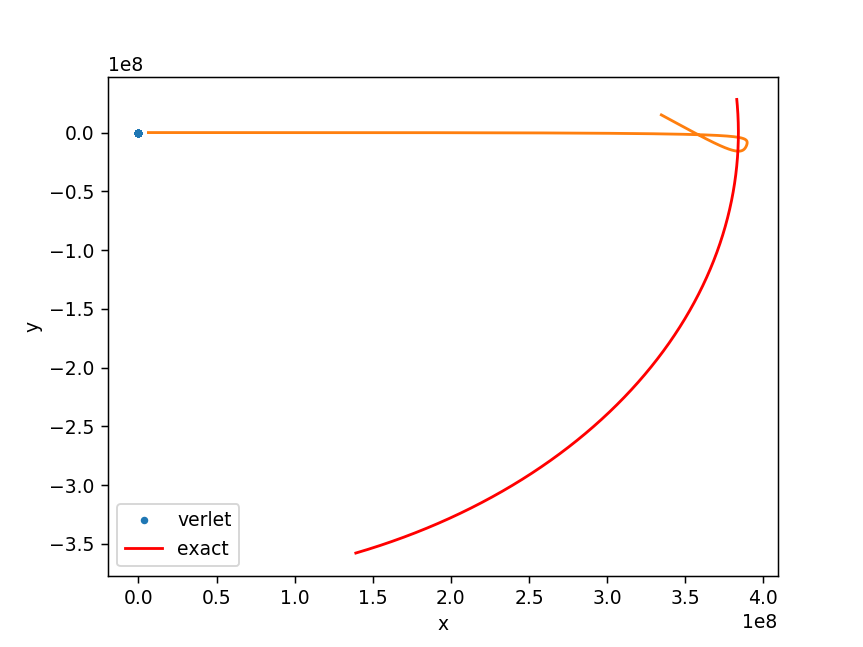

In [9]:
plot(rs[:,0], rs[:,1], '.')
# looks like projectile motion

#exact solution
ts = linspace(0,1,100)
xexact = 0.0 + 1.0*ts
yexact = 3.0 + 5.0*ts -0.5*9.8*ts*ts
plot(xexact, yexact,'r')

xlabel('x')
ylabel('y')
legend(('verlet','exact'),loc=0)

## Shoot the moon

In the shoot the moon problem, the force is proportional to the rocket's mass, and so in the resulting acceleration a = F/m, the rocket's mass cancels.  So we don't need to consider the rocket's mass - we've basically ignored the intial launch portion of the rocket through the atmosphere. 

In [10]:
# python knows physical constants
import scipy.constants as const

In [11]:
G = const.G
G

6.67408e-11

In [12]:
ME = 5.97216787e24   # from google
ME

5.97216787e+24

In [13]:
MM = 7.34767309e22  # from google
MM

7.34767309e+22

In [14]:
# find the moon's period
D = 3.84e8    # this is the radius of the moon

T = sqrt(4.0*pi*pi*D**3/G/ME)

w = sqrt(G*ME/D**3)

print(T, w)

2368181.573023819 2.653168734505811e-06


In [15]:
# find the moon's period
D = 3.84e8    # this is the radius of the moon's orbit

T = sqrt(4.0*pi*pi*D**3/G/ME)

w = sqrt(G*ME/D**3)

print(T, w)

2368181.573023819 2.653168734505811e-06


In [16]:
RE = 6.3781e6
RM = 1.74e6

In [17]:
# solve for initial speed so that rocket would just stop when it reaches the moon's orbit due to Earth's gravity alone

# soln: v0 = sqrt(2*(-G*ME/D + G*ME/RE))

vguess = sqrt(2.0*(-G*ME/D + G*ME/RE))
print(vguess)

11086.488670262115


In [18]:
# So that's a ball park initial velocity for getting out to the moon - 11000 m/s!!!

In [19]:
# Now we need to calculat a(t) of the rocket due to the gravitational force on the rocket due to the earth and moon - mind your signs

# G, ME, MM are all global variables and should be accessible by this function

def at(r, rM):  # r is the position of the rocket and rM is the position of the moon.  Earth is at the origin
    
    # a = F/m.   
    #  the force is Fij = -GMm/(ri-rj)^3 \vec{ri - rj}   - here ri will be the rocket and rj will be either earth or moon
    
    # a due to the earth
    r2 = sum(r*r)   # this gives x*x + y*y for the rocket's positon from earth
    r3 = r2*sqrt(r2)
    
    ax = -G*ME/(r3)*r[0]   # x-component
    ay = -G*ME/(r3)*r[1]   # y-component
    
    # a due to the moon
    
    dr = r - rM  # displacement vector between rocket and moon
    dr2 = sum(dr*dr)
    dr3 = dr2*sqrt(dr2)
    ax += -G*MM/dr3*dr[0]  # add to x-component of a
    ay += -G*MM/dr3*dr[1]  # add to y-component of a
    
    return array([ax, ay])

In [21]:
# Q #5
at(array([RE,0.0]),array([D,0.0]))
# almost -9.8 m/s^2 - so this check's out

array([-9.79804077, -0.        ])

In [12]:
# For sanity let's plot the acceleration as a function of distance along a straight line between the earth and moon

rM = array([D, 0.0])  # let's put the moon right on the x-axis

rxs = linspace(7.5e7, 3.6e8, 100)
accels = []
for rx in rxs:
    r = array([rx, 0.0])  # rocket's position
    accel = at(r, rM )
    accels.append(accel)
accels = array(accels)
shape(accels)

(100, 2)

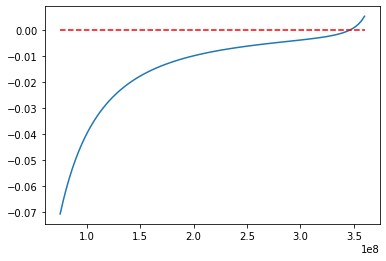

In [28]:
# plot x-acceleration of rocket
plot(rxs, accels[:,0])
plot([rxs[0], rxs[-1]],[0,0],'r--')

In [29]:
# so you have to get pretty close to the moon before it starts pulling the rocket towards it

### Trajectory calculation

(200000, 2) (200000, 2)
earth radius: 6378100.000000
min dist moon: 2875455.417927   min dist return earth: 122302493.437750  tmin: 658188.000000


<IPython.core.display.Javascript object>


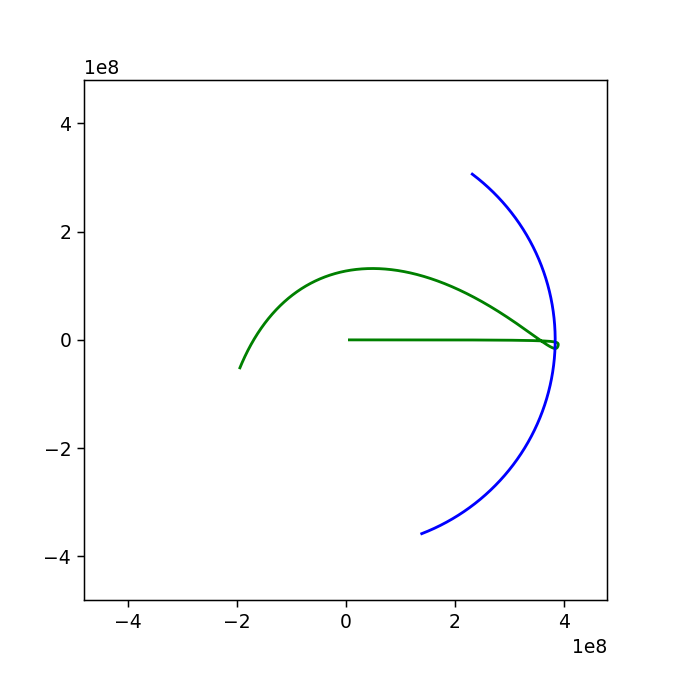

(-480000000.0, 480000000.0)

In [29]:
#  rocket will start at r = (RE, 0) and with v0 = (v0, 0), and moon will be at an angular postion alpha_0 < 0
#  so rM_0 = (D*cos(alpha_0), D*sin(alpha_0))
#
#  at later times, alpha = alpha_0 + w*t

dt = 4.0  # try making 1/2 as big to look at accuracy of solution
Nt = 200000 #120000  # number of time steps - it takes about 2-3 days to get to the moon so need ~ 200000 dts

# initial conditions

v0x = 11088.0
alpha0 = -1.2

t = 0
r0 = array([RE, 0.0])
v0 = array([v0x, 0.0])
rM0 = array([D*cos(alpha0), D*sin(alpha0)])

rs = [r0]   # stores trajectory
rMs = [rM0]  # keeps position of moon
ts = [t]
# use 1st verlet step to calculate next positon
a0 = at(r0, rM0)
r1 = verlet0(r0, v0, a0, dt)
t = t + dt  # update time
ts.append(t)

rs.append(r1)
rM = array([ D*cos(alpha0+w*t), D*sin(alpha0 + w*t) ])
rMs.append(rM)

# now use verlet update rule
for i in range(Nt-2):
    # we are calculating position at t+dt, but positions for rocket and moon for computing accel are from time t.
    
    r0 = rs[-2]  # rocket at t-dt
    r1 = rs[-1]  # rocket at t
    a1 = at(r1, rM)   # acceleration at time t
    
    rt = verlet(r0, r1, a1, dt)
    rs.append(rt)
    t = t+dt
    ts.append(t)
    rM = array([ D*cos(alpha0+w*t), D*sin(alpha0 + w*t) ])
    rMs.append(rM)
    
rs = array(rs)
ts = array(ts)
rMs = array(rMs)
print(shape(rs), shape(rMs))


dmoon = sqrt(sum((rs - rMs)**2,axis=1)) # distance to moon
dearth = sqrt(sum(rs[10000:]**2,axis=1))  # distance to earth after leaving
ii = argmin(dearth)
print('earth radius: %f' % RE)
print('min dist moon: %f   min dist return earth: %f  tmin: %f' % (amin(dmoon), dearth[ii], ts[ii]))

# dreturn = dearth - RE
# ii = where(dreturn < 0)[0]
# if ii != []:  # returned
#     print('min dist moon: %f   min dist return earth: %f  tmin: %f' % (amin(dmoon), amin(dreturn), ts[ii[0]]))
# else:
#     print(' no return')
    
fig = figure(figsize=(5,5))

plot(rs[:,0], rs[:,1],  'g-')
plot(rMs[:,0], rMs[:,1],  'b-')
xlim(-1.25*D, 1.25*D)
ylim(-1.25*D, 1.25*D)


In [30]:
# function that returns moon and rocket trajectory

def traj(alpha0, v0x, dt, Nt):
    
#  rocket will start at r = (RE, 0) and with v0 = (v0, 0), and moon will be at an angular postion alpha_0 < 0
#  so rM_0 = (D*cos(alpha_0), D*sin(alpha_0))
#
#  at later times, alpha = alpha_0 + w*t


    t = 0
    r0 = array([RE, 0.0])
    v0 = array([v0x, 0.0])
    rM0 = array([D*cos(alpha0), D*sin(alpha0)])

    rs = [r0]   # stores trajectory
    rMs = [rM0]  # keeps position of moon
    ts = [t]
    # use 1st verlet step to calculate next positon
    a0 = at(r0, rM0)
    r1 = verlet0(r0, v0, a0, dt)
    t = t + dt  # update time
    ts.append(t)

    rs.append(r1)
    rM = array([ D*cos(alpha0+w*t), D*sin(alpha0 + w*t) ])
    rMs.append(rM)

    # now use verlet update rule
    for i in range(Nt-2):
        # we are calculating position at t+dt, but positions for rocket and moon for computing accel are from time t.

        r0 = rs[-2]  # rocket at t-dt
        r1 = rs[-1]  # rocket at t
        a1 = at(r1, rM)   # acceleration at time t

        rt = verlet(r0, r1, a1, dt)
        rs.append(rt)
        t = t+dt
        ts.append(t)
        rM = array([ D*cos(alpha0+w*t), D*sin(alpha0 + w*t) ])
        rMs.append(rM)

    rs = array(rs)
    ts = array(ts)
    rMs = array(rMs)

    return ts, rs, rMs


In [68]:
ts, rs, rMs = traj(-0.6, 11130.0, 4.0, 200000 )

<IPython.core.display.Javascript object>


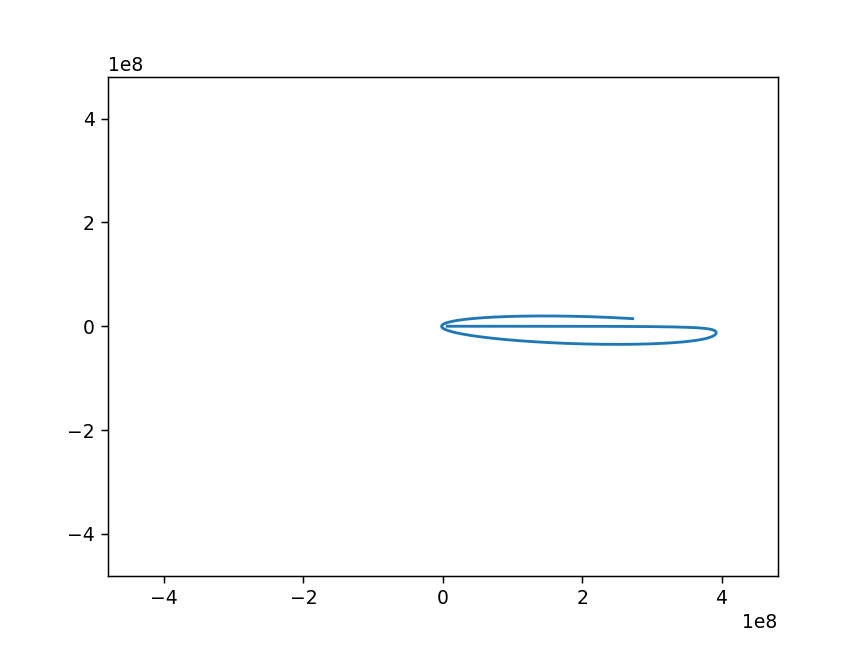

(-480500000.0, 480500000.0)

In [106]:
plot(rs[:,0], rs[:,1])
xlim(-1.25*D, 1.25*D)
ylim(-1.25*D, 1.25*D)

In [ ]:
# map out alphas and v0's that work for a few alphas by hand
# for alpha = -1.0, v0x ~ 11088 gets around the moon 
#           = -0.8, v0x ~ 11100
#           = -0.6, v0x ~ 11130

In [74]:
# now do a fine loop that iterates over alphas and v0's
#
# want to map out distance of closest approach as a function of v0x and alpha and time to return

Nt = 200000  # days*hours*seconds
dt = 5.0
ts = arange(0.0, Nt*dt, dt)

alphas = [-1.0, -0.8, -0.6]
vguess = {-1.0:11088.0, -0.8:11100.0, -0.6:11130.0}  # starting guesses for each alpha
dv = 1.0  # velocity increments

Rcut = 1.5*RE  # distance of closest approach to earth - if it's within this then it's a good trajectory

dmins = {}   # dictionaries to store values
vs = {}

for alpha0 in alphas:
    
    dmins[alpha0] = []
    vs[alpha0] = []
    
    # step through vs
    v0s = arange(vguess[alpha0]-10.0, vguess[alpha0]+10.0, dv )

    print('doing alpha', alpha0, v0s[0], v0s[-1])

    for v0 in v0s:
        ts, rs, rMs = traj(alpha0, v0, dt, Nt)

        dearth = sqrt(sum(rs**2,axis=1))   # x^2 + y^2 of rocket
        dmoon = sqrt(sum( (rs - rMs )**2, axis=1))

        dmax = amax(dearth)  # furthest distance from earth
        if dmax > D: # gone past moon - needs to do that
            ii = where(dearth > D)[0]   # all points that have gone past moon
            dreturn = amin(dearth[ii[0]:])
            if dreturn <= Rcut:     # good trajectory - made it back to earth
                print(alpha0, v0, dreturn, amin(dmoon))
                vs[alpha0].append(v0)
                dmins[alpha0].append(amin(dmoon))

doing alpha -1.0 11078.0 11097.0
-1.0 11080.0 2663569.7657366646 19481742.93803103
-1.0 11090.0 5858870.215048084 6657438.002982127
-1.0 11091.0 982921.7289427613 9673061.32792402
-1.0 11092.0 163630.0426454597 12737645.394976163
-1.0 11093.0 172239.8363944842 15811257.62530288
-1.0 11094.0 157598.92635944486 18874420.793585174
-1.0 11095.0 204778.50921055273 21916517.840322
-1.0 11096.0 216794.4281760105 24931264.314962935
-1.0 11097.0 245882.13688307608 27914713.802579686
doing alpha -0.8 11090.0 11109.0
-0.8 11097.0 7776244.841777335 2896845.1403994616
-0.8 11098.0 215119.20755448693 4606673.296667878
-0.8 11099.0 742368.6100600202 6402068.165193029
-0.8 11100.0 1851128.836063056 8233496.465505064
-0.8 11101.0 2492841.7049908037 10076486.598136997
-0.8 11102.0 2757139.4717867505 11917945.289069729
-0.8 11103.0 2800555.1376772965 13750388.313739046
-0.8 11104.0 2728394.804743745 15569318.60121396
-0.8 11105.0 2600962.0399380364 17371933.901316304
-0.8 11106.0 2451604.135929149 191564

<IPython.core.display.Javascript object>


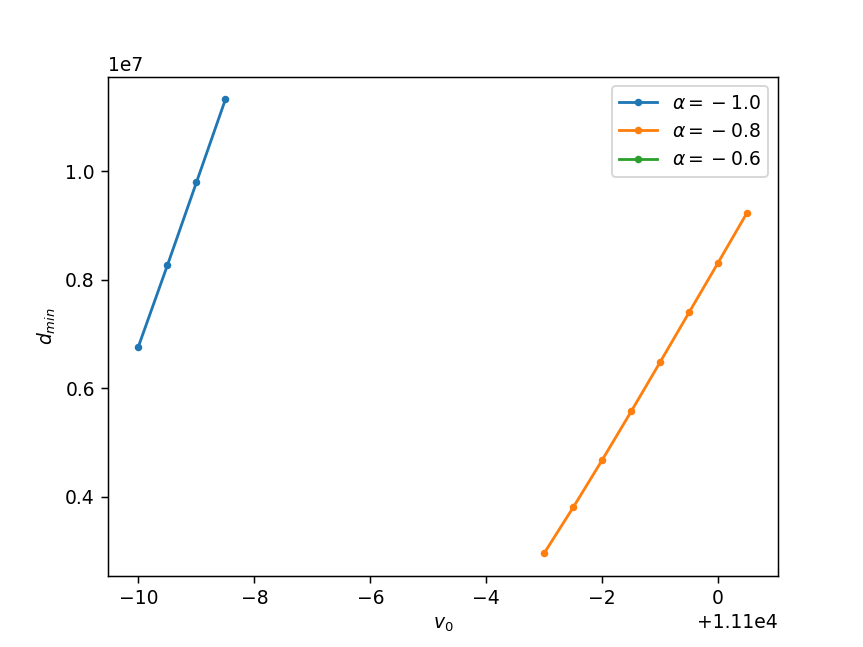

In [105]:
plot(vs[-1.0], dmins[-1.0],'.-')
plot(vs[-0.8], dmins[-0.8],'.-')
plot(vs[-0.6], dmins[-0.6],'.-')
ylabel(r'$d_{min}$')
xlabel(r'$v_0$')
legend((r'$\alpha=-1.0$',r'$\alpha=-0.8$',r'$\alpha=-0.6$'),loc=0)

So the distance of closest approach goes down with the initial velocity and overall gets smaller with increasing (smaller) inital angle of the moon.  There is clearly one point on the blue curve that probably was an error in the trajectory calculation that required a smaller dt.

## animating things (not graded)

In [92]:
from matplotlib import animation

In [103]:
alpha0 = -0.8
v0 = 11100.0
dt = 4.0
Nt = 200000
ts, rs, rMs = traj(alpha0, v0, dt, Nt)

<IPython.core.display.Javascript object>


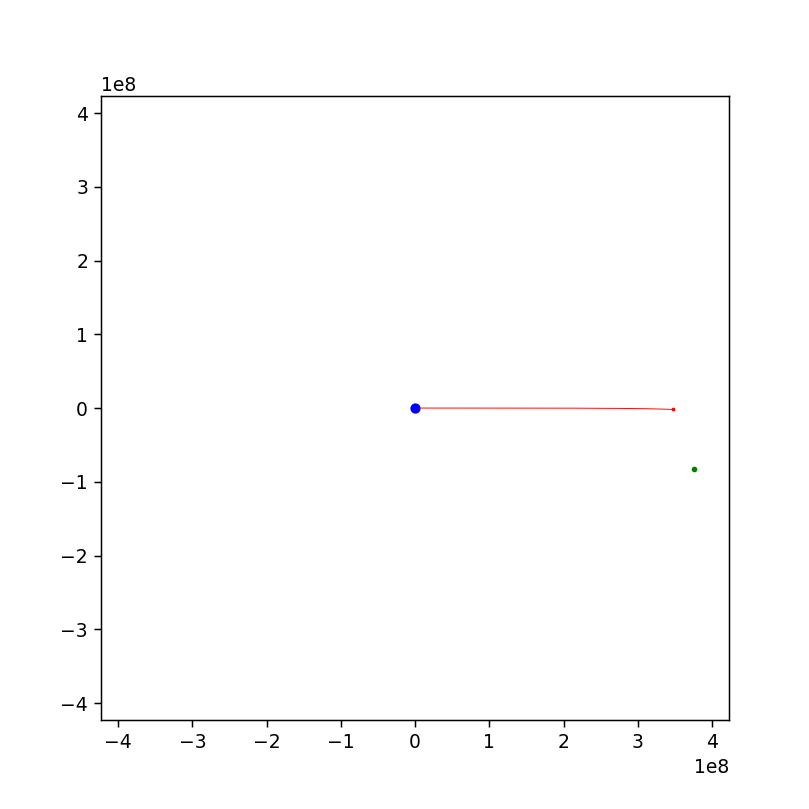

In [104]:
fig = figure(figsize=(6,6))
# feel free to change the x,y limits
xlim(-1.1*D,1.1*D)
ylim(-1.1*D,1.1*D)

# rs contains  a Nt x 2 list of the rockets postions
# rMs contains a Nt x 2 list of the Moon's positions 
scatE = scatter([0.0], [0.0], s=20, c='b')  # plots the Earth
scat = scatter(rs[0,0], rs[0,1], s=1, c='r') # plot the first rocket point
line, = plot(rs[0,0], rs[0,1], lw=0.5, c='r') # starts a line of the rocket's trajectory
scatM = scatter(rMs[0,0], rMs[0,1], s=4, c='g') # plot the moon's first position

# need an update functions
def update_plot(i):
    scat.set_offsets(rs[i])  # updates to the ith position
    scatM.set_offsets(rMs[i])
    line.set_data(rs[:i,0], rs[:i,1])
    return line,

ani = animation.FuncAnimation(fig, update_plot, frames=arange(0, len(rs), 1000), interval=1)
